<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Examples Using the `dask` Module](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.04-dask.delayed-Via-Slurm.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Appendix A: Command Reference](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/A.00-Appendix-A.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.05-Ligand-Docking-dask.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Part I: Parallelized Global Ligand Docking with `pyrosetta.distributed`

*Warning*: This notebook uses `pyrosetta.distributed.viewer` code, which runs in `jupyter notebook` and might not run if you're using `jupyterlab`.

*Note:* This Jupyter notebook uses parallelization and is **not** meant to be executed within a Google Colab environment.

*Note:* This Jupyter notebook requires the PyRosetta distributed layer which is obtained by building PyRosetta with the `--serialization` flag or installing PyRosetta from the RosettaCommons conda channel

**Please see the setup instructions in Chapter 16.00**

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.dask
import pyrosetta.distributed.io as io
import pyrosetta.distributed.packed_pose as packed_pose
import pyrosetta.distributed.tasks.rosetta_scripts as rosetta_scripts
import pyrosetta.distributed.tasks.score as score
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys

from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress, as_completed
from IPython import display

if 'google.colab' in sys.modules:
    print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
    sys.exit(0)

Setup PyRosetta command line flags:

In [2]:
ligand_params = "inputs/TPA.am1-bcc.fa.params"
flags = f"""
-extra_res_fa {ligand_params}
-ignore_unrecognized_res 1
-out:level 200
"""
pyrosetta.distributed.init(flags)

INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-extra_res_fa inputs/TPA.am1-bcc.fa.params -ignore_unrecognized_res 1 -out:level 200', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/klimaj/anaconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.02+release.22ef835b4a2647af94fcd6421a85720f07eddf12 2020-01-05T17:31:56] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


Setup `dask` workers to run ligand docking simulations:

In [3]:
if not os.getenv("DEBUG"):
    scratch_dir = os.path.join("/net/scratch", os.environ["USER"]) # Change to your scratch directory
    cluster = SLURMCluster(cores=1,
                           processes=1,
                           job_cpu=1,
                           memory="3GB",
                           queue="short",
                           walltime="02:59:00",
                           local_directory=scratch_dir,
                           job_extra=["-o {}".format(os.path.join(scratch_dir, "slurm-%j.out"))],
                           extra=pyrosetta.distributed.dask.worker_extra(init_flags=flags))
    n_workers = 20
    cluster.scale(n_workers)
    client = Client(cluster)
else:
    cluster, client = None, None

In [4]:
client

Client Scheduler: tcp://172.16.131.107:18073 Dashboard: http://172.16.131.107:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Setup global ligand docking RosettaScripts protocol within `pyrosetta.distributed`:

In [5]:
xml = """
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
  </SCOREFXNS>
  <RESIDUE_SELECTORS>
    <Chain name="chX" chains="X"/>
  </RESIDUE_SELECTORS>
  <SIMPLE_METRICS>
    <RMSDMetric name="rmsd_chX" residue_selector="chX" reference_name="store_native" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
  </SIMPLE_METRICS>
  <SCORINGGRIDS ligand_chain="X" width="25">
    <ClassicGrid grid_name="vdw" weight="1.0"/>
  </SCORINGGRIDS>
  <LIGAND_AREAS>
    <LigandArea name="docking_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true" minimize_ligand="10"/>
    <LigandArea name="final_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true"/>
    <LigandArea name="final_backbone_X" chain="X" cutoff="7.0" add_nbr_radius="false" all_atom_mode="true" Calpha_restraints="0.3"/>
  </LIGAND_AREAS>
  <INTERFACE_BUILDERS>
    <InterfaceBuilder name="side_chain_for_docking" ligand_areas="docking_sidechain_X"/>
    <InterfaceBuilder name="side_chain_for_final" ligand_areas="final_sidechain_X"/>
    <InterfaceBuilder name="backbone" ligand_areas="final_backbone_X" extension_window="3"/>
  </INTERFACE_BUILDERS>
  <MOVEMAP_BUILDERS>
    <MoveMapBuilder name="docking" sc_interface="side_chain_for_docking" minimize_water="true"/>
    <MoveMapBuilder name="final" sc_interface="side_chain_for_final" bb_interface="backbone" minimize_water="true"/>
  </MOVEMAP_BUILDERS>
  <MOVERS>
    <SavePoseMover name="spm" restore_pose="0" reference_name="store_native"/>
    <Transform name="transform" chain="X" box_size="20.0" move_distance="10" angle="360" initial_perturb="2" cycles="500" repeats="5" temperature="1000"/>
    <HighResDocker name="high_res_docker" cycles="9" repack_every_Nth="3" scorefxn="fa_standard" movemap_builder="docking"/>
    <FinalMinimizer name="final" scorefxn="fa_standard" movemap_builder="final"/>
  </MOVERS>
  <FILTERS>
      <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
      <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
  </FILTERS>
  <PROTOCOLS>
    <Add mover="spm"/>
    <Add mover="transform"/>
    <Add mover="high_res_docker"/>
    <Add mover="final"/>
    <Add filter="interfE"/>
    <Add filter="rmsd_chX"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
"""
xml_obj = rosetta_scripts.SingleoutputRosettaScriptsTask(xml)
xml_obj.setup()

Setup input pose as `PackedPose` object:

In [6]:
pose_obj = io.pose_from_file(filename="inputs/test_lig.pdb")

Submit 100 global ligand docking trajectories, very similar to using command line `-nstruct` flag:

In [7]:
if not os.getenv("DEBUG"):
    futures = [client.submit(xml_obj, pose_obj) for i in range(100)]
    results = [future.result() for future in futures]

As results accumulate, you may wish to keep an eye on the progress bar in the `dask` dashboard.

The called `future.result()` transfers the `PackedPose` objects back to this Jupyter session, so we can inspect the scores in memory!

In [8]:
if not os.getenv("DEBUG"):
    df = pd.DataFrame.from_records(packed_pose.to_dict(results))
else:
    df = pd.DataFrame()
df.head(10)

,interfE,rmsd_chX,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_intra_sol_xover4,lk_ball_wtd,fa_elec,pro_close,...,hbond_sc,dslf_fa13,omega,fa_dun,p_aa_pp,yhh_planarity,ref,rama_prepro,total_score,pickled_pose
0,-4.310011,10.997455,-2130.421364,1372.830226,1342.091523,1567.159132,92.416371,-46.938660,-480.843762,73.297583,...,-20.281951,0.0,18.053992,2857.865936,-84.797614,0.888190,81.74634,121.092490,1519.496943,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
1,-8.195594,3.577211,-2135.910044,1318.839250,1335.130959,1547.841577,89.528559,-46.535040,-494.360305,112.373971,...,-26.992728,0.0,35.874193,2796.785539,-82.061873,0.459685,81.74634,121.579602,1464.965851,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
2,-11.780600,10.575939,-2108.091527,1427.892584,1315.435127,1569.009467,91.189021,-47.187082,-477.396443,73.368136,...,-20.403877,0.0,9.313265,2937.585191,-82.630985,0.182146,81.74634,122.942322,1598.446543,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
3,-0.488049,10.196235,-2133.253857,1308.852951,1330.667092,1569.550466,90.640954,-48.087869,-487.683161,90.501048,...,-26.772007,0.0,16.721523,2877.101694,-81.773872,0.768894,81.74634,118.714493,1486.058971,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
4,-9.646654,8.200747,-2141.088456,1355.053989,1350.135926,1555.036380,95.491082,-49.469960,-495.744410,112.964123,...,-24.894757,0.0,24.439469,2848.390589,-84.245172,0.653257,81.74634,122.317473,1527.550166,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
5,-28.049520,0.410507,-2139.844163,1340.995350,1340.559376,1486.966604,90.701248,-49.300368,-512.861177,92.580508,...,-27.259618,0.0,28.276716,2812.418716,-83.225966,0.577041,81.74634,119.882265,1436.749142,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
6,-5.690134,7.620458,-2130.595116,1354.924302,1334.472949,1557.508418,91.275502,-50.127856,-501.494557,90.156339,...,-22.113947,0.0,20.892161,2836.642389,-80.592124,0.408904,81.74634,122.775680,1480.337855,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
7,14.108461,10.286517,-2126.883065,1448.345060,1340.929737,1557.858541,91.888944,-50.352979,-473.366614,100.846834,...,-17.972557,0.0,12.739968,2954.099768,-81.498249,0.318019,81.74634,126.208785,1672.480828,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
8,7.068296,12.266051,-2120.110236,1440.787969,1334.509376,1561.362908,88.834847,-46.673847,-472.052175,73.222180,...,-21.723378,0.0,11.727213,2931.140423,-84.009779,0.881952,81.74634,124.730197,1613.066484,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...
9,-16.541498,4.480207,-2138.568676,1526.769708,1334.117940,1558.405903,91.668703,-50.730091,-478.995700,90.225311,...,-23.088410,0.0,19.319679,2872.540493,-83.013527,0.145924,81.74634,121.200031,1613.064400,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...


Now plot the ligand binding energy landscape:

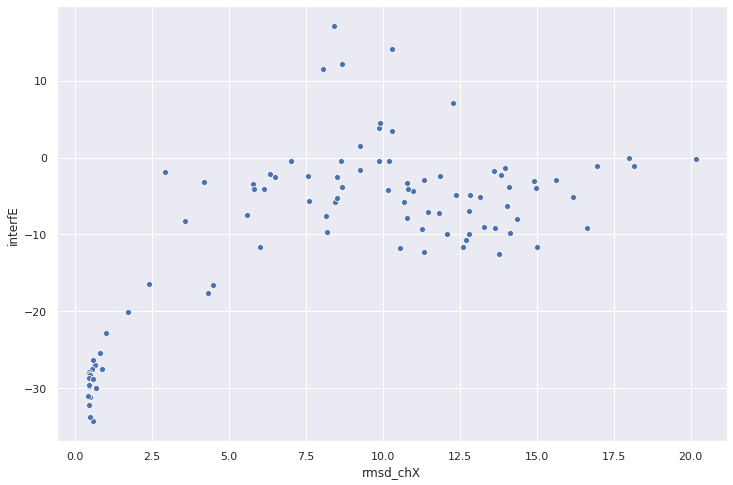

In [9]:
if not os.getenv("DEBUG"):
    matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
    seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)

Let's look at the lowest energy model according to `interfE`!

In [10]:
if not os.getenv("DEBUG"):
    lowest_energy_df = df["interfE"].sort_values()
    lowest_energy_index = lowest_energy_df.index[-1]
    lowest_energy_pose = results[lowest_energy_index]

    view = viewer.init(lowest_energy_pose)
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
    view.add(viewer.setHydrogenBonds())
    view.add(viewer.setZoomTo(residue_selector=pyrosetta.rosetta.core.select.residue_selector.ChainSelector("X")))
    view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

View the five lowest energy poses according to `interfE`:

In [11]:
if not os.getenv("DEBUG"):
    lowest_energy_poses = list(packed_pose.dict_to_pose(df.sort_values(by="interfE").head(5).to_dict()).values())
    view = viewer.init(lowest_energy_poses)
    view.add(viewer.setStyle())
    view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
    view.add(viewer.setHydrogenBonds())
    view.add(viewer.setZoomTo(residue_selector=pyrosetta.rosetta.core.select.residue_selector.ChainSelector("X")))
    view()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Decoys', max=4), Output()), _do…

If you wish to save any `PackedPose` objects as `.pdb` files:

In [ ]:
# for i, p in enumerate(results):
#     with open("outputs/RESULT_%i.pdb" % i, "w") as f:
#         f.write(io.to_pdbstring(p))

If you wish to save a scorefile:

In [ ]:
# with open(os.path.join("outputs", "ligand_docking_scores.fasc"), "w") as f:
#     for result in results:
#         json.dump(result.scores, f)

# Part II: Parallelized Global Ligand Docking with `dask.distributed.as_completed` and `pyrosetta.distributed`

Example using `dask.distributed.as_completed()` function:

"Give me at least 5 global ligand docks where the ligand RMSD is at least 0.4 Angstroms from the input ligand coordinates.":

After 160 dock(s), the lowest rmsd_chX is 0.39600881934165955


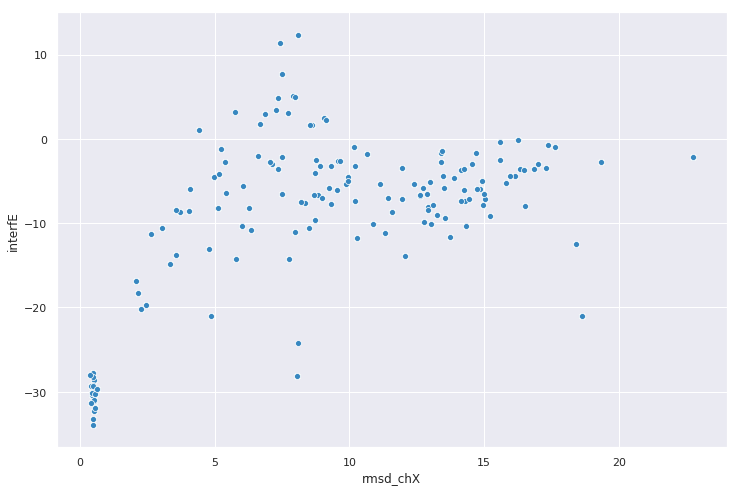

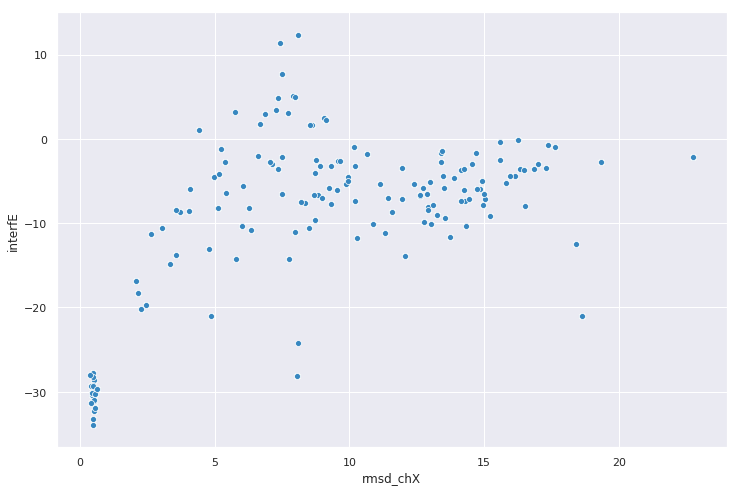

In [20]:
from IPython import display
import matplotlib.pyplot as plt
if not os.getenv("DEBUG"):
    with seaborn.color_palette("Blues_d", n_colors=1):
        nstruct = n_workers
        futures = [client.submit(xml_obj, pose_obj) for j in range(nstruct)]
        seq = as_completed(futures, with_results=True)

        results = []
        for i, (future, result) in enumerate(seq, start=1):

            # Update dataset
            results.append(result)
            df = pd.DataFrame.from_records(packed_pose.to_dict(results))
            lowest_rmsd_chX = df["rmsd_chX"].sort_values().values[0]

            # Update display
            display.clear_output(wait=True)
            print(f"After {i} dock(s), the lowest rmsd_chX is {lowest_rmsd_chX}")
            seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)
            display.display(plt.gcf())

            # Submit more futures if condition is not met
            if (i >= nstruct) and (not lowest_rmsd_chX <= 0.4):
                nstruct += n_workers
                for j in range(n_workers):
                    seq.add(client.submit(xml_obj, pose_obj))
else:
    df = pd.DataFrame()

View resulting scores in the order they completed:

In [21]:
df

,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,hbond_bb_sc,hbond_lr_bb,...,lk_ball_wtd,omega,p_aa_pp,pickled_pose,pro_close,rama_prepro,ref,rmsd_chX,total_score,yhh_planarity
0,0.0,-2109.618677,2987.532787,-460.804889,1559.392664,89.338830,1458.616496,1311.399444,-44.488264,-47.474618,...,-47.848602,2.151970,-82.041905,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,77.684772,126.412105,81.74634,14.902432,1671.067996,0.001560
1,0.0,-2105.305311,3030.807182,-473.205698,1565.130192,88.835417,1466.777358,1306.459782,-44.193357,-47.478300,...,-47.121203,2.086357,-83.405589,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,107.356720,125.158339,81.74634,13.538095,1727.336287,0.034064
2,0.0,-2091.360701,2920.175148,-458.826812,1549.394863,89.453679,1414.442840,1290.735470,-43.107482,-48.027345,...,-45.137232,3.902656,-85.342361,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,60.624014,125.865720,81.74634,14.128614,1577.831018,0.003817
3,0.0,-2112.834614,3042.513417,-473.404657,1571.410352,91.188546,1438.914976,1316.596837,-46.476363,-48.967521,...,-45.276509,0.378058,-84.547864,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,90.257290,116.533949,81.74634,11.305335,1695.618878,0.317765
4,0.0,-2109.328779,2972.604335,-465.324664,1566.721694,90.843550,1464.755765,1309.718084,-45.480755,-48.664992,...,-48.883264,2.703349,-81.230578,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,69.661009,127.680286,81.74634,12.924160,1646.933591,0.568650
5,0.0,-2105.875106,3005.359107,-469.423503,1566.750444,90.932732,1431.706080,1307.627006,-46.425932,-47.498704,...,-49.178075,1.584126,-81.226150,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,73.785812,116.678258,81.74634,13.518868,1646.780415,0.318403
6,0.0,-2098.265444,2999.853778,-480.017785,1566.494637,91.157908,1434.674832,1305.641416,-47.730424,-47.898621,...,-46.782256,3.223878,-83.081812,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,73.755589,117.291586,81.74634,12.783246,1641.040765,0.432204
7,0.0,-2110.698465,2869.381021,-460.049169,1567.186498,92.688303,1441.397298,1310.055850,-45.114707,-48.420000,...,-46.953026,1.985867,-82.933240,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,68.282715,117.970601,81.74634,16.523289,1562.130649,0.005626
8,0.0,-2112.557027,3006.368632,-482.342878,1583.026679,91.840579,1435.416531,1325.239038,-46.112840,-47.094844,...,-47.120504,4.112792,-81.840670,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,73.961269,118.710661,81.74634,18.389835,1651.309911,0.525410
9,0.0,-2140.951789,2815.279697,-499.213543,1492.173947,91.568987,1395.512136,1341.710954,-49.993331,-48.131888,...,-47.493369,14.691859,-79.592624,gANjcHlyb3NldHRhLnJvc2V0dGEuY29yZS5wb3NlClBvc2...,112.802109,121.506811,81.74634,3.046977,1509.839941,0.175492


<!--NAVIGATION-->
< [Examples Using the `dask` Module](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.04-dask.delayed-Via-Slurm.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Appendix A: Command Reference](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/A.00-Appendix-A.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.05-Ligand-Docking-dask.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>